This live script walks you through the steps of discrete Fourier transform (DFT) and illustrates some of the principles that help or hinder the application of DFT in EEG analysis, inlcuding practical application


The goal of FFT is to take time domain data (EEG over time) and give you a frequency spectrum (Frequency domain data), i.e. a plot where frequency is on the x and the power or magnitude at each frequency is on the y-axis. 


In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.signal as sig

First, load the example data. 

In [7]:
#loads our example data set (129 sensors, 2551 points, 41 trials)
bop_107 = sio.loadmat('octave/bop_107.fl40h1.E1.app1.mat') 
print(bop_107['outmat'].shape)

outmat = bop_107['outmat']

tx = sio.loadmat('octave/taxis.mat')
taxis = np.squeeze(tx['taxis'].copy())

# since the mat-file is saved as version 5.0 it's easy to load
#import h5py # it might be possible to load matfiles > v.5.0 with the h5py package

(129, 2551, 41)


Text(0.5, 1.0, 'Our example data')

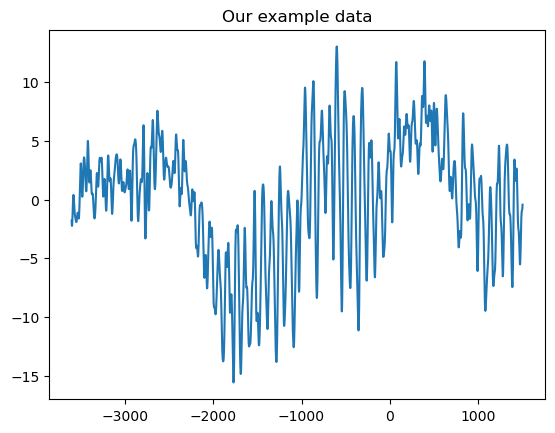

In [8]:
SampRate = 500
data = outmat[68,:, 40] # this picks the 68th channel and the 40th trial (out of 41).

# squeeze gets rid of third dimension tha matlab wants to keep around, even
# though we only have one column vector of data now

data = np.squeeze(outmat[68,:, 40]).T 

plt.figure()
plt.plot(taxis,data)
plt.title ('Our example data')

# squeeze gets rid of third dimension tha matlab wants to keep around, even
# though we only have one column vector of data now

**Question**: *Why is it interesting to pick a trial from late in the experiment?* 

Now, do a barebone DFT (FFT)...

/Users/mears/Applications/anaconda3/envs/neo2mne/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


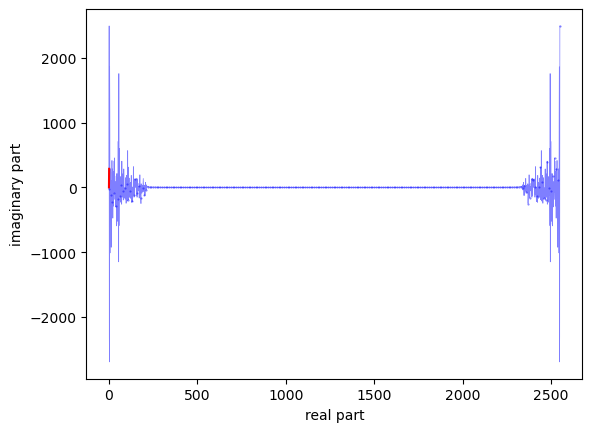

what is the nature of the output of FFT ?
(2551,)
complex128
[  -22.98196983-2.22044605e-15j  2492.06356673+3.22454130e+03j
 -2305.39541363-3.70078031e+03j -2694.39821119+4.02999156e+02j
  1859.41643754-1.34571640e+03j  1148.06371927+2.91674492e+02j
 -1012.65138774-4.89639769e+02j   286.32733801+2.51270351e+02j
  -180.57417294-6.81456783e+01j   151.38417814+3.13877707e+02j]


In [10]:
NFFT= len(data)
fftMat = np.fft.fft(data, NFFT) # in matlab FFT always acros rows within columns
plt.plot(fftMat,'b',linewidth=0.5,alpha=0.5, marker='o',markersize=0.5,markevery=10)
plt.xlabel('real part')
plt.ylabel('imaginary part')
plt.plot([0, fftMat[7]], 'r') # this is one frequency
plt.show()

print('what is the nature of the output of FFT ?')
print(fftMat.shape)
print(fftMat.dtype)
print(fftMat[0:10])


We see that the out put is "complex" so there are two numbers per number in the output, resulting in a 2-D plot.  

Also, the size of the output (fftMat) is the same as the input (2551 points) ... 



In [11]:
# ![image.png](attachment:image.png)
RawMag = np.abs(fftMat)
Phase = np.angle(fftMat)

Raw magnitude at each frequency is the modulus (sqrt if the sum of the squares) of the two parts (real and imag). So, the length of the arrow spanned by the real and imag part in the plot above. 

Phase is the angle between real and imaginary (see above) 

Let's plot the result, focusing on power/magnitude.

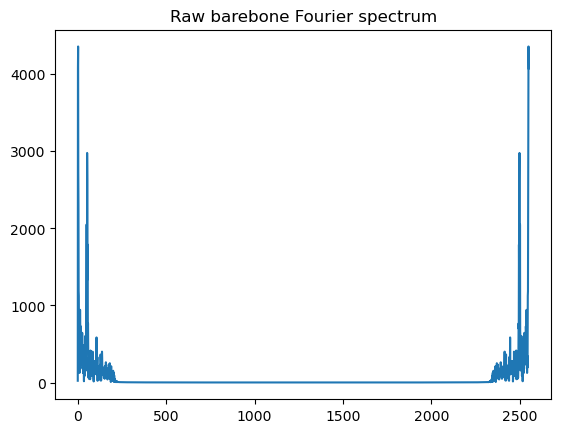

In [12]:
plt.plot(RawMag)
plt.title('Raw barebone Fourier spectrum')
plt.show()

Note how this spectrum is symmetrical. 
This is because of this: 

In [13]:
# ![image.png](attachment:image.png)

This is called the Nyquist sampling theorem. If you sample a signal digitally, any frequencies greater than half the sampling rate are meaningless repetitions of the actual ones below half the sampling rate. half the sampling rate = Nyquist frequency. 

If we apply the logic from the slides of Day 1, namely that the frequency resolution (the steps between x-ticks or bins) is 1000/length of the signal, it follows that the frequency steps here are 1000/(2551.*2) = 0.1960. Thus, 


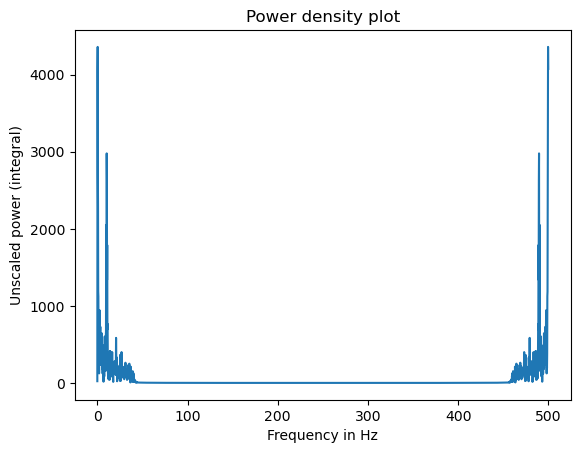

In [14]:
freq_axis = np.arange(0, SampRate, SampRate/NFFT)
plt.plot(freq_axis, RawMag)
plt.xlabel('Frequency in Hz')
plt.ylabel('Unscaled power (integral)')
plt.title('Power density plot')
plt.show()

Because of the Nyquist theorem, we may really only interpret the spectrum up onto half of the sampling rate, here in this example up to 250 Hz, the rest of the spectrum (above 250 Hz) is not valid. Below, we take this into account as we calculate the power. But first, power is overall greater when the signal is longer. This is bad when wanting to compare spectra from different studies, or different EEG segments, with different length. Below, we see how less data result in smaller power. 


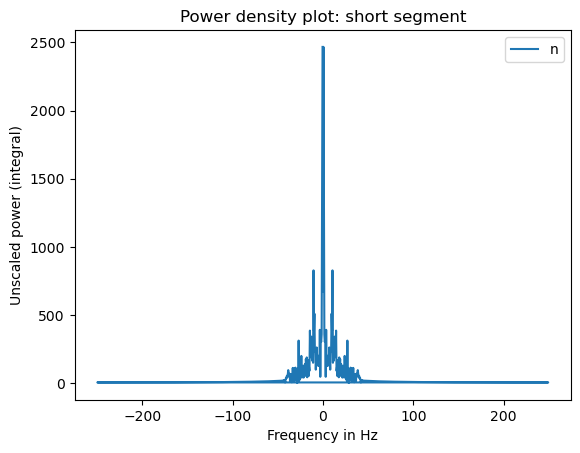

In [15]:
# calculate power with shorter segment
fftMatshort = np.fft.fft(data[0:1000]) #just 2 seconds of data
magshort = np.abs(fftMatshort)
#freq_axis_short  = np.arange(0, 1000/(len(data[0:1000])*2), SampRate-0.5)
freq_axis_short=np.fft.fftfreq(len(data[0:1000]), d=1/SampRate)

plt.plot(freq_axis_short, magshort)
plt.xlabel('Frequency in Hz')
plt.ylabel('Unscaled power (integral)')
plt.title('Power density plot: short segment')
plt.legend('note the overall lower power !')
plt.show()

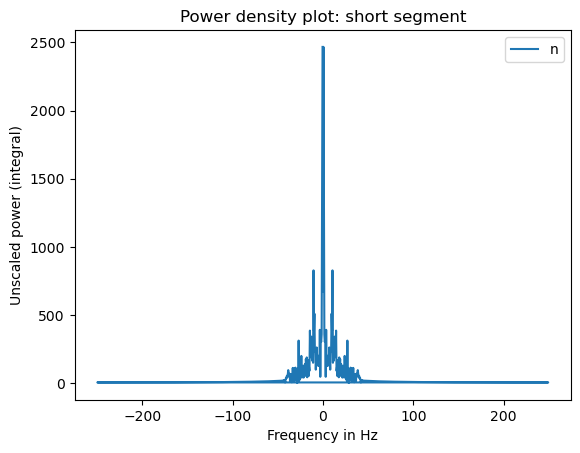

In [16]:
freq_axis_short=np.fft.fftfreq(len(data[0:1000]), d=1/SampRate)
fix_freq_axis_short=np.fft.fftshift(freq_axis_short)
plt.plot(freq_axis_short, magshort)
plt.xlabel('Frequency in Hz')
plt.ylabel('Unscaled power (integral)')
plt.title('Power density plot: short segment')
plt.legend('note the overall lower power !')
plt.show()

Now we consider only the part of the spectrum that is valid and scale the power values, so that the true lower half of the spectrum contains all the power in the signal. We do this for the full signal, not the short one above. 


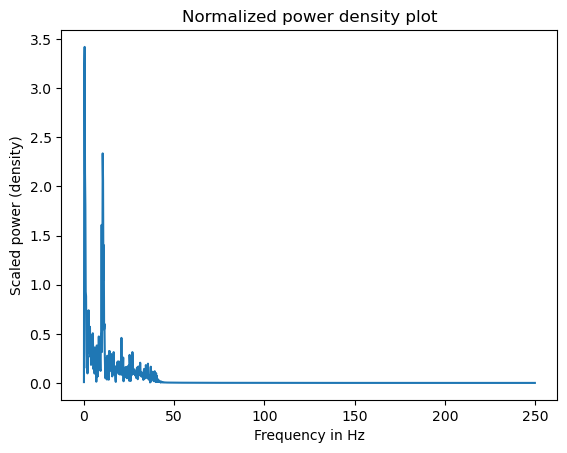

In [17]:
Mag = RawMag*2 # multiply by two, then use only lower half
Mag[0] = Mag[0]/2 # the first value (zero Hz) was not symmetric, so no correction here.
Mag = Mag/NFFT # scale by the number of points, so we can compare long and short segments etc
spec = Mag[0:round(NFFT/2)] # take only lower half of the spectrum and plot it
plt.plot(freq_axis[0:1276], spec)
plt.xlabel('Frequency in Hz')
plt.ylabel('Scaled power (density)')
plt.title('Normalized power density plot')
plt.show()

Now we have scaled power, but the plot shows irrelevant (filtered) frequency.   
  
Let's zoom in.

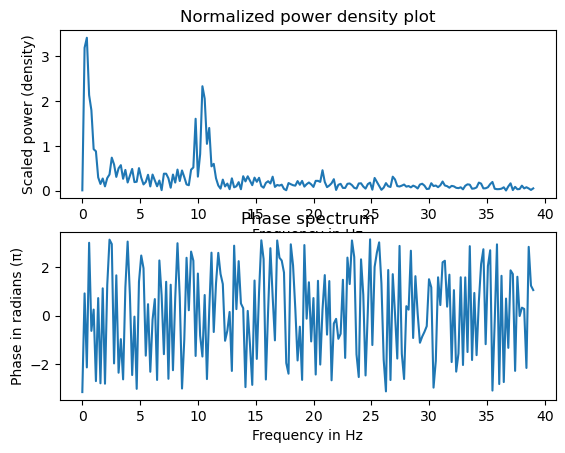

In [18]:
plt.subplot(2,1,1)
plt.plot(freq_axis[0:200], spec[0:200])
plt.xlabel('Frequency in Hz')
plt.ylabel('Scaled power (density)')
plt.title('Normalized power density plot')
plt.subplot(2,1,2)
plt.plot(freq_axis[0:200], Phase[0:200])
plt.xlabel('Frequency in Hz')
plt.ylabel('Phase in radians (π)')
plt.title('Phase spectrum')
plt.show()

Congrats! this is a valid FFT/DFT.   

For some applications, this version with no windowing and no averaging within the time segment is best. 

## Part 2: improving the signal-to noise of the estimate. 

The spectrum on the right is noisy looking and has higher frequency resolution (many x-ticks) than we might want. Instead we would like a clear shape and nice signal. In Matlab and most other enviornments, people often use a version of Welch's method, where a window is moved over the signal, DFTs are calculated, and averaged as they are moved. 

From the `scipy` package in Python here is how this works, all in one command: 

In [19]:
Pxx,F=sig.welch(data, SampRate, nperseg=500, noverlap=250, nfft=500) # 50% OVERLAP is the default

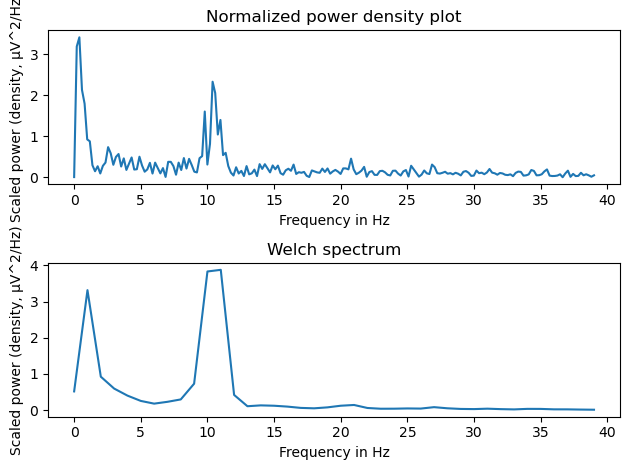

In [20]:
plt.subplot(2,1,1)
plt.plot(freq_axis[0:200], spec[0:200])
plt.xlabel('Frequency in Hz')
plt.ylabel('Scaled power (density, µV^2/Hz)')
plt.title('Normalized power density plot')
plt.subplot(2,1,2)
plt.plot(Pxx[0:40],F[0:40])
plt.xlabel('Frequency in Hz')
plt.ylabel('Scaled power (density, µV^2/Hz)')
plt.title('Welch spectrum')
plt.tight_layout()
plt.show()

Note how the welch spectrum has fewer frequency steps because we used many shorter segments within our data segment, did a spectrum, and averaged the resulting spectra together, to obtain a much smmother, high signal-to-noise version. 


Finally, windows are also sometimes useful, even without averaging, because they minimize/attenuate on and offset artifacts. The sine and cosine functions that the DFT uses as models for the data are infinite and stationary (see slides), thus they create artfifacts at the beginning and end of the signal. 


Text(0.5, 1.0, 'A Hanning window, one of many window types')

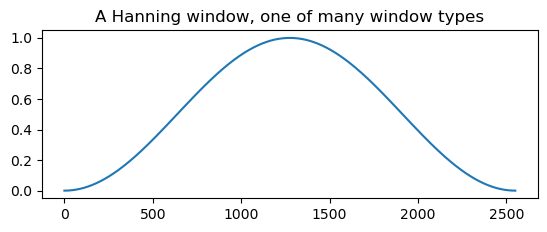

In [21]:
window = np.hanning(2551)
plt.subplot(2,1,1)
plt.plot(window)
plt.title('A Hanning window, one of many window types')

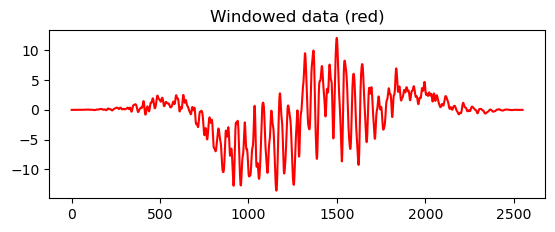

In [22]:
datawindowed = data*window #we multiply this with the data, pointwise
plt.subplot(2,1,2)
plt.plot(datawindowed, 'r')
plt.title('Windowed data (red)')
plt.show()

Compare this with the original data

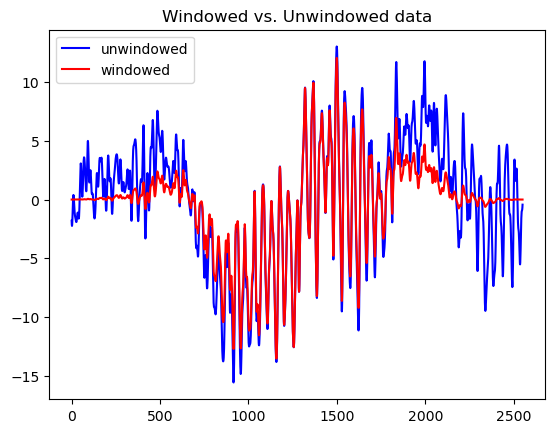

In [23]:
plt.plot(data, 'b',label='unwindowed')
plt.plot(datawindowed, 'r',label='windowed')
plt.title('Windowed vs. Unwindowed data')
plt.legend()
plt.show()

 Now, we redo the power spectrum for the windowed data.

In [24]:
fftwindowed=np.fft.fft(datawindowed)
RawMagwindowed = np.abs(fftwindowed)
Magwindowed = RawMagwindowed*2 # multiply by two, then use only lower half
Magwindowed[0] = Magwindowed[0]/2 # the first value (zero Hz) was not symmetric, so no correction here.
Magwindowed = Magwindowed/NFFT # scale by the number of points, so we can compare long and short segments etc
specwindowed = Magwindowed[0:round(NFFT/2)] # take only lower half of the spectrum and plot it

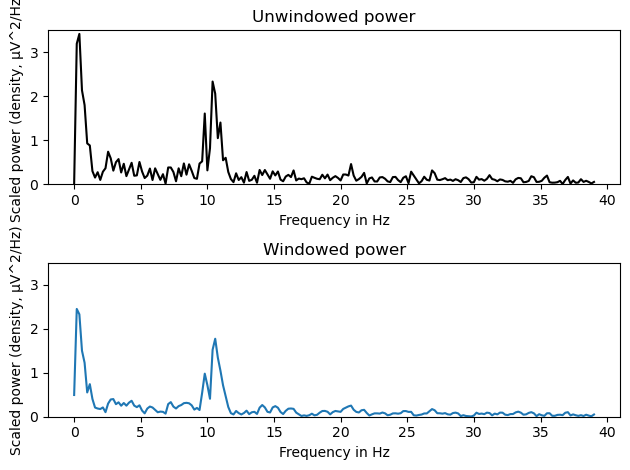

In [25]:
plt.subplot(2,1,1)
plt.plot(freq_axis[0:200], spec[0:200], 'k')
plt.ylim([0,3.5])
plt.xlabel('Frequency in Hz')
plt.ylabel('Scaled power (density, µV^2/Hz)') 
plt.title('Unwindowed power')

plt.subplot(2,1,2)
plt.plot(freq_axis[0:200], specwindowed[0:200])
plt.ylim([0,3.5])
plt.xlabel('Frequency in Hz')
plt.ylabel('Scaled power (density, µV^2/Hz)')
plt.title('Windowed power')

plt.tight_layout()
plt.show()

Note the smaller value at 0 (zero) Hz in the windowed version, and its overall smoother look. Sometimes windowing is beneficial because of these effects. Also note the overall smaller/lower power in the windowed version. If no window is necessarym this is an undesirabel effect of using unneeded windows. 